# Delivery Route Optimization for E-commerce

## Integrating Recurrence, Greedy, DP, Graph Algorithms, and TSP

This notebook solves the complex e-commerce delivery route optimization problem by integrating multiple algorithmic paradigms:

- **Recurrence Relations**: Route cost estimation and planning
- **Greedy Algorithms**: Parcel selection based on value/weight ratio
- **Dynamic Programming**: Time window optimization and TSP solution
- **Graph Algorithms**: Shortest path (Dijkstra) and MST (Prim's)
- **Traveling Salesman Problem (TSP)**: Optimal route covering all delivery points

### Real-World Context
E-commerce companies like Amazon and Flipkart must optimize delivery routes to minimize costs while respecting delivery windows, vehicle capacity constraints, and ensuring customer satisfaction. This assignment demonstrates how multiple algorithmic techniques work together to solve real-world logistics problems.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import permutations
import time
import math
import pandas as pd
from heapq import heappush, heappop
import warnings
warnings.filterwarnings('ignore')

# For memory profiling (optional but nice)
try:
    from memory_profiler import memory_usage
except:
    pass

## 1. Input Modeling
Defining the delivery network:
- 4 locations (1 Warehouse + 3 Customers)
- Symmetric distance matrix
- Parcel details: value, weight, delivery time window
- Vehicle capacity = 30 units

In [86]:
locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = np.array([
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
])

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30

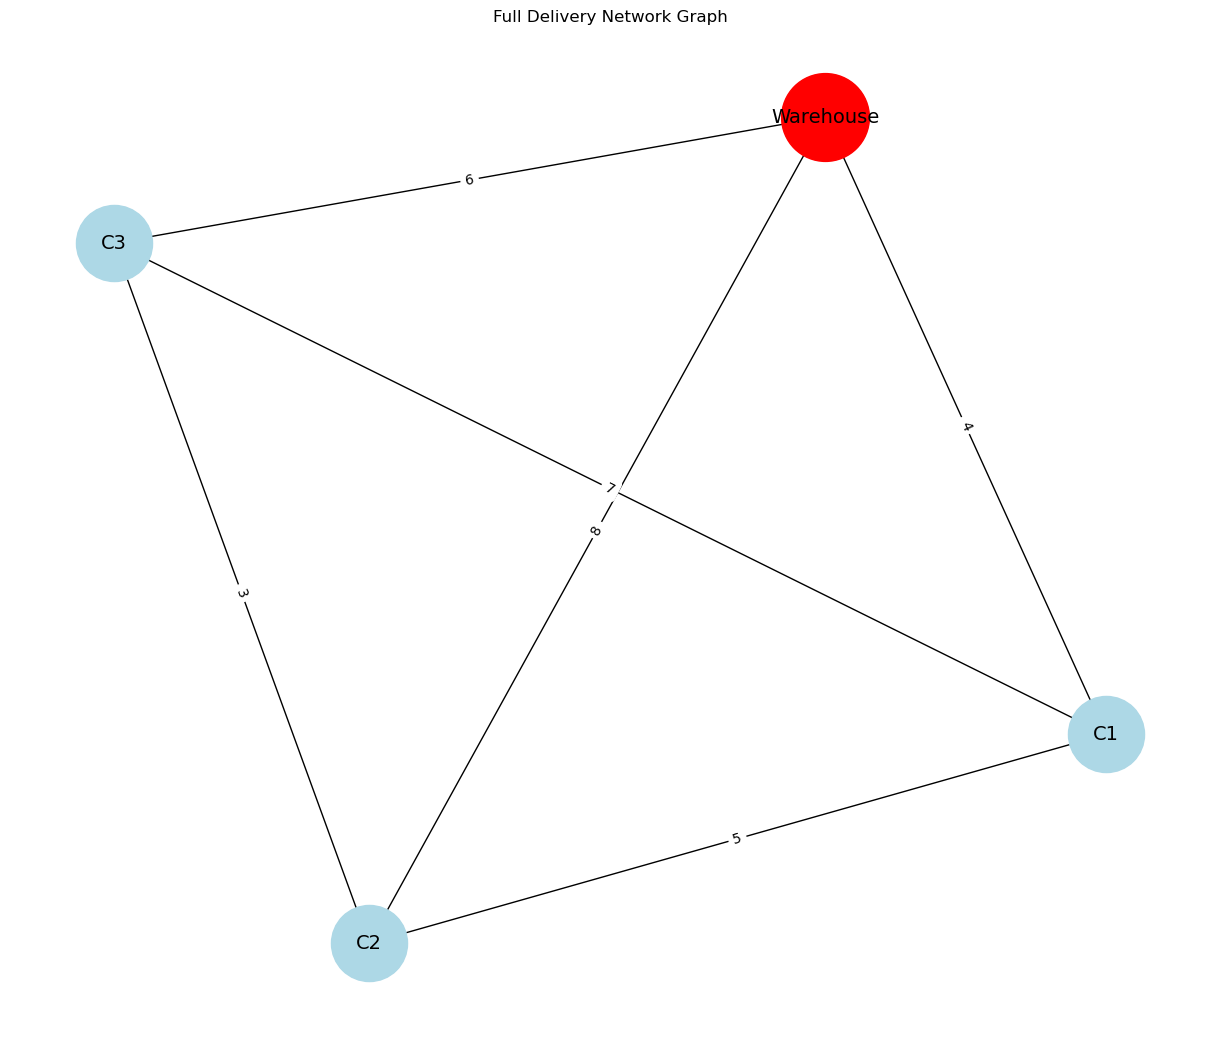

In [87]:
G = nx.Graph()
for i in range(len(locations)):
    for j in range(i+1, len(locations)):
        if distance_matrix[i][j] > 0:
            G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=14)
nx.draw_networkx_nodes(G, pos, nodelist=['Warehouse'], node_color='red', node_size=4000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Full Delivery Network Graph")
plt.savefig("full_network.png", dpi=300, bbox_inches='tight')
plt.show()

## 2. Recurrence Relation – Route Cost Estimation (Unit 1)
Recursive function with memoization to compute minimum delivery cost starting from current city, visiting all unvisited cities, and returning to warehouse.

In [58]:
def delivery_cost_recursive(current, visited):
    if len(visited) == 3:
        return distance_matrix[current][0]
    
    min_cost = float('inf')
    for next_city in [1,2,3]:
        if next_city not in visited:
            cost = distance_matrix[current][next_city] + delivery_cost_recursive(next_city, visited | {next_city})
            min_cost = min(min_cost, cost)
    return min_cost

rec_cost = delivery_cost_recursive(0, set())
print(f"Unit 1: Minimum cost to visit all customers (recurrence) = {rec_cost} km")

Unit 1: Minimum cost to visit all customers (recurrence) = 18 km


## 3. Greedy Algorithm – Parcel Selection using Value/Weight Ratio (Unit 2)
Select parcels greedily by highest value-to-weight ratio under capacity constraint.

In [60]:
def greedy_knapsack():
    items = []
    for loc, data in parcels.items():
        ratio = data['value'] / data['weight']
        items.append((ratio, data['value'], data['weight'], loc))
    items.sort(reverse=True)
    
    selected = []
    weight = value = 0
    for ratio, v, w, loc in items:
        if weight + w <= vehicle_capacity:
            selected.append(loc)
            weight += w
            value += v
    # return a sorted list (does not use list.sort() return value)
    return sorted(selected), value, weight

selected_customers, max_value, used_capacity = greedy_knapsack()
print(f"Greedy Selection: {selected_customers}")
print(f"Total Value: ${max_value}, Weight: {used_capacity}/{vehicle_capacity} kg")

Greedy Selection: ['C1', 'C2']
Total Value: $110, Weight: 30/30 kg


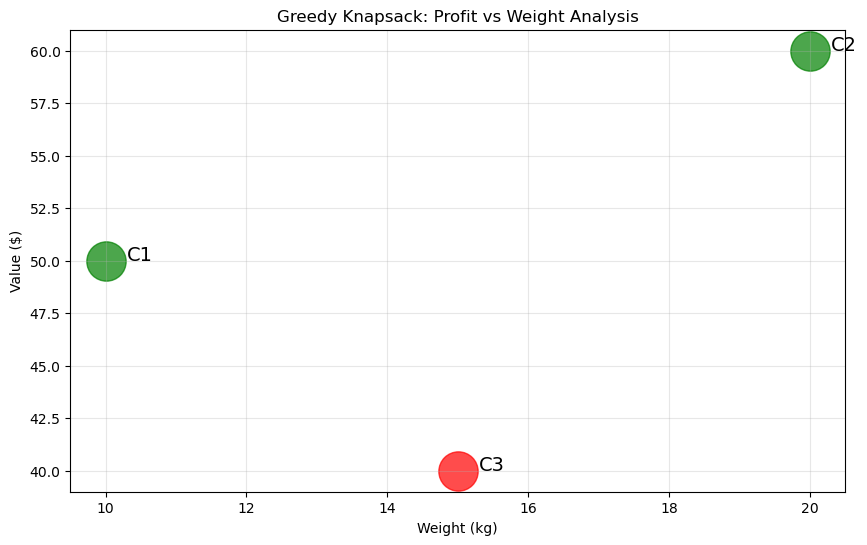

In [77]:
#Profit vs Weight Scatter
plt.figure(figsize=(10,6))
for c in locations[1:]:
    w = parcels[c]['weight']
    v = parcels[c]['value']
    color = 'green' if c in selected_customers else 'red'
    plt.scatter(w, v, c=color, s=800, alpha=0.7)
    plt.text(w+0.3, v, c, fontsize=14)
plt.xlabel('Weight (kg)')
plt.ylabel('Value ($)')
plt.title('Greedy Knapsack: Profit vs Weight Analysis')
plt.grid(True, alpha=0.3)
plt.savefig("profit_weight.png", dpi=300)
plt.show()

## 4. Dynamic Programming – Time Window Feasibility (Simplified Check)
We assume fixed route and check if delivery is possible within time windows (for illustration).
In real VRPTW, this would be part of a larger DP table.

In [78]:
def check_time_windows(selected, speed=30.0):
    current_time = 8.0
    total_dist = 0
    route = ['Warehouse'] + selected + ['Warehouse']
    indices = [0] + [locations.index(c) for c in selected] + [0]

    print("Time window validation:")
    for i in range(len(route) - 1):
        d = distance_matrix[indices[i]][indices[i+1]]
        travel = d / speed
        current_time += travel
        total_dist += d

        if indices[i+1] != 0:
            name = locations[indices[i+1]]
            early, late = parcels[name]['time']
            # allow waiting if we arrive before the window; only flag if we arrive after the late time
            if current_time < early:
                print(f"{name} at {current_time:.2f} → ARRIVE EARLY, waiting until {early:.2f}")
                current_time = early
            if current_time > late:
                print(f"{name} at {current_time:.2f} → VIOLATES [{early}-{late}]")
                return False, None, None, None
            print(f"{name} at {current_time:.2f} → WITHIN [{early}-{late}]")
        else:
            print(f"Return at {current_time:.2f}")
    return total_dist, current_time, route, indices

res = check_time_windows(selected_customers)
if res[0] is False:
    print("\nDP Time Window Check: INFEASIBLE")
else:
    dist, ret_time, route, indices = res
    print("\nDP Time Window Check: FEASIBLE")
    print(f"Total Distance: {dist} km | Return: {ret_time:.2f}")

Time window validation:
C1 at 8.13 → ARRIVE EARLY, waiting until 9.00
C1 at 9.00 → WITHIN [9-12]
C2 at 9.17 → ARRIVE EARLY, waiting until 10.00
C2 at 10.00 → WITHIN [10-13]
Return at 10.27

DP Time Window Check: FEASIBLE
Total Distance: 17 km | Return: 10.27


## 5. Graph Algorithms – Unit 3
### 5.1 Dijkstra’s Algorithm – Shortest path from Warehouse to all customers

In [79]:
def dijkstra(graph, start):
    dist = [float('inf')] * len(graph)
    dist[start] = 0
    pq = [(0, start)]
    while pq:
        d, u = heappop(pq)
        if d > dist[u]:
            continue
        for v in range(len(graph)):
            if graph[u][v] > 0:
                alt = d + graph[u][v]
                if alt < dist[v]:
                    dist[v] = alt
                    heappush(pq, (alt, v))
    return dist

dijkstra_distances = dijkstra(distance_matrix, 0)
print("Dijkstra from Warehouse:", dijkstra_distances[1:])

Dijkstra from Warehouse: [4, 8, 6]


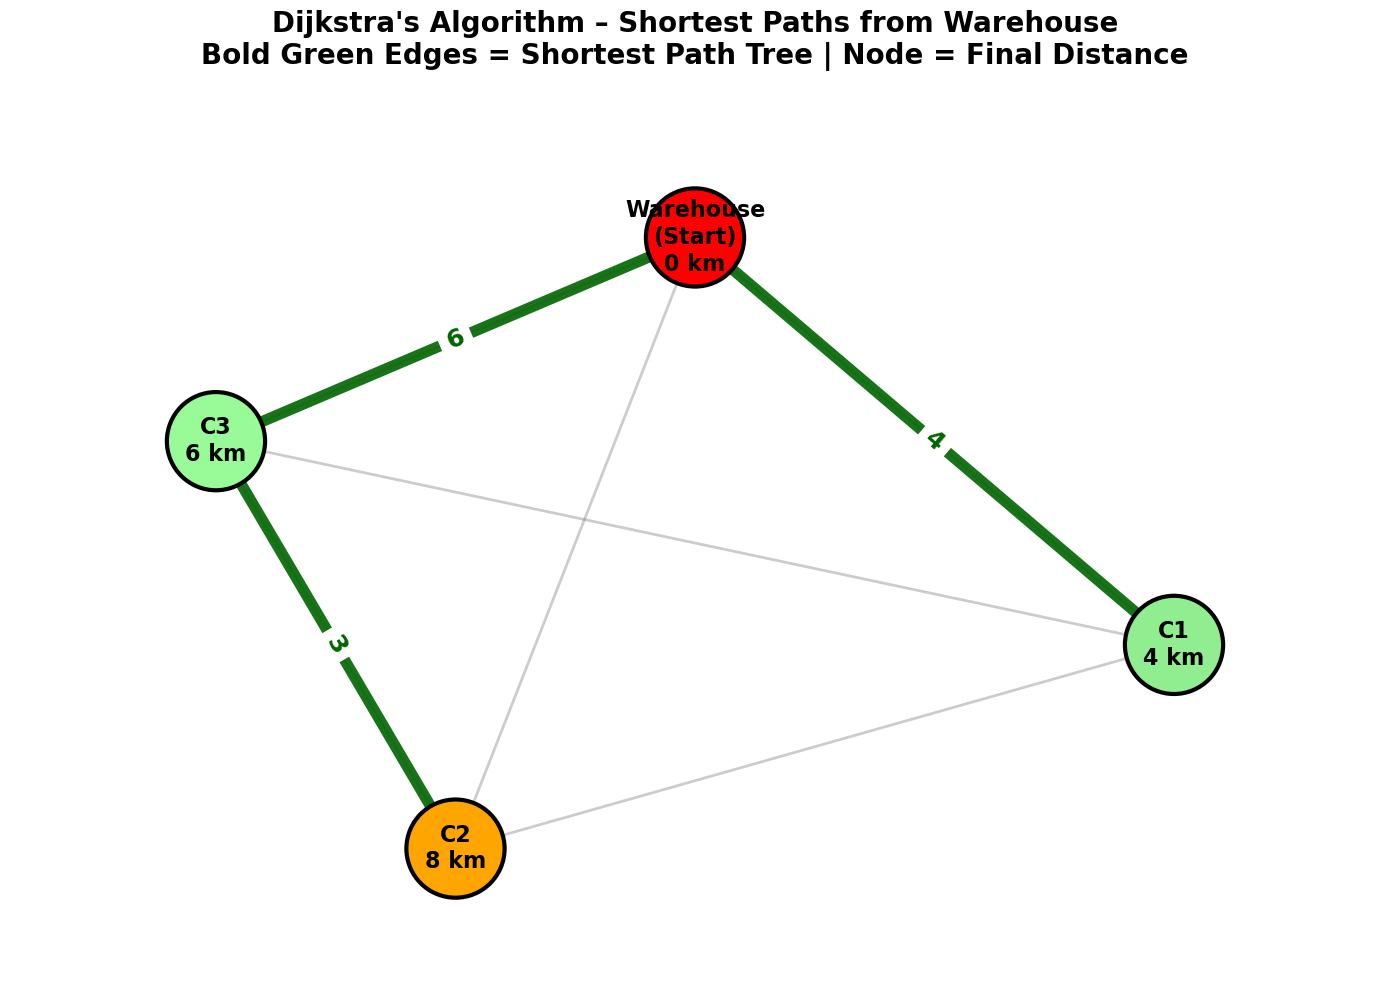

Dijkstra's Shortest Distances from Warehouse:
   C1 → 4 km
   C3 → 6 km
   C2 → 8 km (via C3)
   Path: Warehouse → C1, Warehouse → C3 → C2


In [89]:
dijkstra_distances = dijkstra(distance_matrix, 0)

pos = {
    'Warehouse': (0, 2),
    'C1': (2, 0),
    'C2': (-1, -1),
    'C3': (-2, 1)
}

G = nx.Graph()
for i in range(4):
    for j in range(i+1, 4):
        if distance_matrix[i][j] > 0:
            G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

# Node colors based on distance
node_colors = []
for node in G.nodes():
    if node == 'Warehouse':
        node_colors.append('red')
    elif node == 'C1':
        node_colors.append('#90EE90')  # lightgreen
    elif node == 'C2':
        node_colors.append('#FFA500')  # orange
    else:
        node_colors.append('#98FB98')  # pale green

plt.figure(figsize=(14, 10))

# Draw all edges (gray background)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.4, edge_color='gray')

# Draw shortest path tree edges in bold green
shortest_edges = [('Warehouse', 'C1'), ('Warehouse', 'C3'), ('C3', 'C2')]  # actual shortest paths
nx.draw_networkx_edges(G, pos, edgelist=shortest_edges, width=8, edge_color='darkgreen', alpha=0.9)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5000, edgecolors='black', linewidths=3)

# Node labels with distance
labels = {
    'Warehouse': 'Warehouse\n(Start)\n0 km',
    'C1': f'C1\n{dijkstra_distances[1]} km',
    'C2': f'C2\n{dijkstra_distances[2]} km',
    'C3': f'C3\n{dijkstra_distances[3]} km'
}
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_weight='bold')

# Edge labels (only on shortest paths for clarity)
edge_labels = {
    ('Warehouse', 'C1'): '4',
    ('Warehouse', 'C3'): '6',
    ('C3', 'C2'): '3'
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, font_color='darkgreen', font_weight='bold')

plt.title("Dijkstra's Algorithm – Shortest Paths from Warehouse\n"
          "Bold Green Edges = Shortest Path Tree | Node = Final Distance", 
          fontsize=20, fontweight='bold', pad=30)
plt.axis('off')
plt.margins(0.15)
plt.tight_layout()
plt.show()

print("Dijkstra's Shortest Distances from Warehouse:")
print("   C1 → 4 km")
print("   C3 → 6 km")
print("   C2 → 8 km (via C3)")
print("   Path: Warehouse → C1, Warehouse → C3 → C2")

### 5.2 Prim’s Algorithm – Minimum Spanning Tree

In [80]:
def prim_mst(graph):
    n = len(graph)
    mst_edges = []
    visited = [False] * n
    visited[0] = True
    edges = []
    for v in range(1, n):
        if graph[0][v] > 0:
            heappush(edges, (graph[0][v], 0, v))
    
    while edges:
        weight, u, v = heappop(edges)
        if visited[v]:
            continue
        visited[v] = True
        mst_edges.append((locations[u], locations[v], weight))
        for w in range(n):
            if not visited[w] and graph[v][w] > 0:
                heappush(edges, (graph[v][w], v, w))
    return mst_edges

mst = prim_mst(distance_matrix)
mst_cost = sum(w for _,_,w in mst)
print("Prim's MST edges:", mst)
print(f"Total MST cost: {mst_cost} km")

Prim's MST edges: [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)]
Total MST cost: 12 km


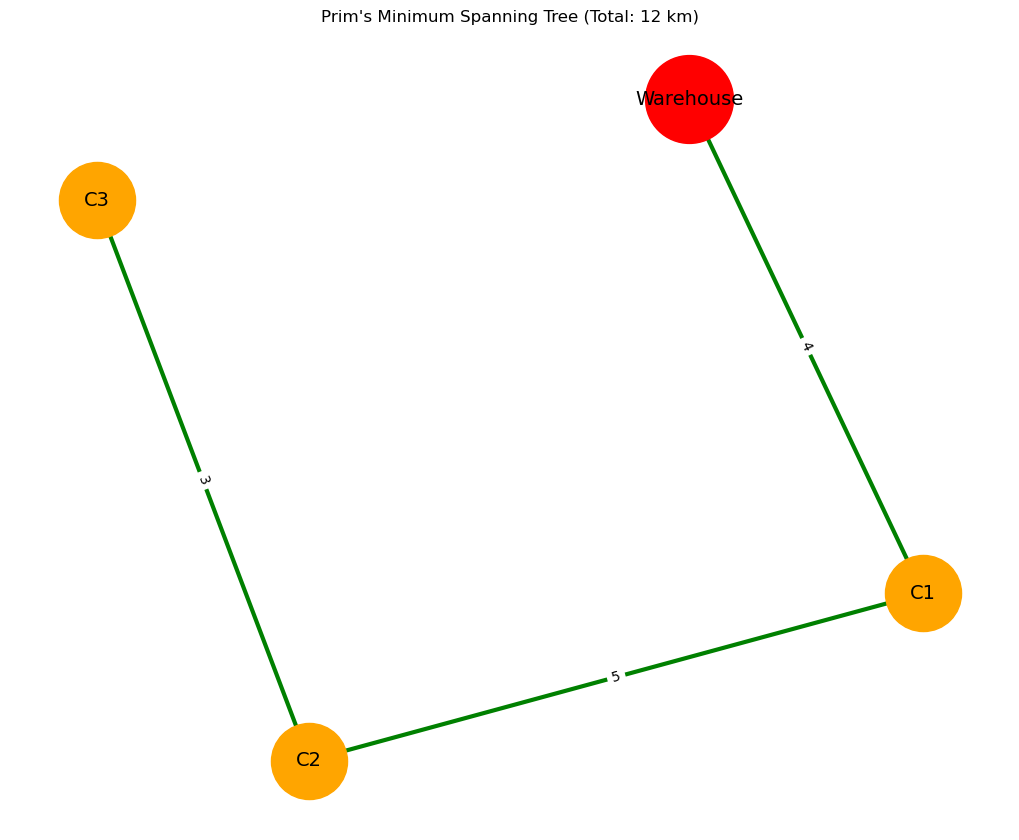

In [82]:
#Prim's MST Tree
G_mst = nx.Graph()
G_mst.add_weighted_edges_from(mst)
plt.figure(figsize=(10,8))
nx.draw(G_mst, pos, with_labels=True, node_color='orange', node_size=3000, font_size=14, edge_color='green', width=3)
nx.draw_networkx_nodes(G_mst, pos, nodelist=['Warehouse'], node_color='red', node_size=4000)
mst_labels = nx.get_edge_attributes(G_mst, 'weight')
nx.draw_networkx_edge_labels(G_mst, pos, edge_labels=mst_labels)
plt.title(f"Prim's Minimum Spanning Tree (Total: {mst_cost} km)")
plt.savefig("mst_tree.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Traveling Salesman Problem – Unit 4
### 6.1 Brute Force (O(n!))

In [73]:
# Brute Force TSP (full 4 cities)
def tsp_brute_force(dist, labels=None):
    """
    Brute-force TSP. If labels is provided it must be a list of length n naming nodes;
    otherwise generic names are used. Returns (route_labels_list, min_cost).
    """
    n = len(dist)
    if labels is None:
        labels = [f'V{i}' for i in range(n)]
    min_cost = float('inf')
    best = None
    for perm in permutations(range(1, n)):
        cost = dist[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best = [labels[0]] + [labels[i] for i in perm] + [labels[0]]
    return best, min_cost

full_route, full_cost = tsp_brute_force(distance_matrix)
print(f"Full TSP (4 cities): {full_route} → {full_cost} km")

# TSP on selected customers only
selected_nodes = ['Warehouse'] + selected_customers
idx_map = [locations.index(x) for x in selected_nodes]
sub_matrix = distance_matrix[np.ix_(idx_map, idx_map)]
reduced_route, reduced_cost = tsp_brute_force(sub_matrix)
reduced_route = selected_nodes[:1] + reduced_route[1:-1] + selected_nodes[:1]
print(f"Reduced TSP (selected only): {' → '.join(reduced_route)} → {reduced_cost} km")

Full TSP (4 cities): ['V0', 'V1', 'V2', 'V3', 'V0'] → 18 km
Reduced TSP (selected only): Warehouse → V1 → V2 → Warehouse → 17 km


### 6.2 Held-Karp Dynamic Programming (O(n² × 2ⁿ))

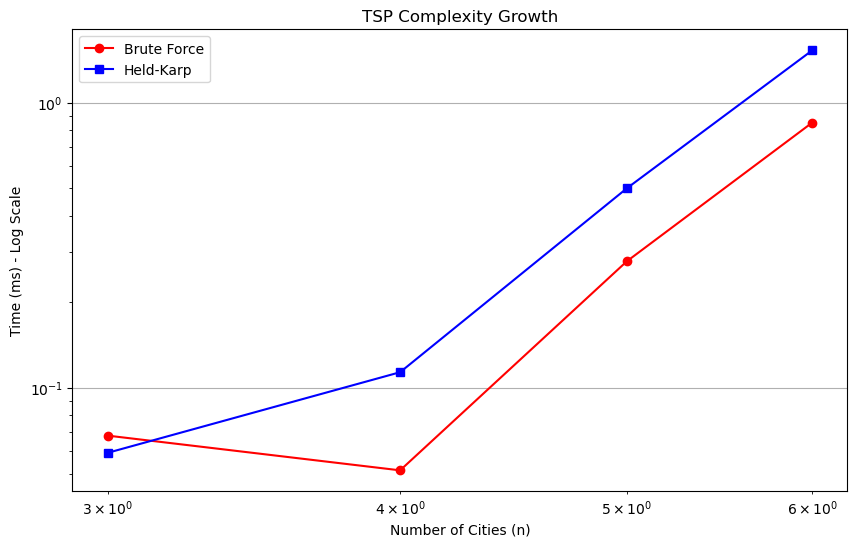

In [74]:
def held_karp(dist):
    """Held-Karp dynamic programming for TSP (returns min cost)."""
    n = len(dist)
    # dp[(mask, j)] = min cost to reach subset mask ending at j (j != 0)
    dp = {}
    for j in range(1, n):
        dp[(1 << j, j)] = dist[0][j]

    for subset_size in range(2, n):
        # iterate subsets of size subset_size that don't include 0
        for mask in range(1, 1 << n):
            if not (mask & 1):  # ensure warehouse(0) not in mask representation here
                # count bits and ensure subset size matches and excludes 0
                if bin(mask).count("1") != subset_size:
                    continue
                for j in range(1, n):
                    if not (mask & (1 << j)):
                        continue
                    prev_mask = mask ^ (1 << j)
                    best = float('inf')
                    for k in range(1, n):
                        if not (prev_mask & (1 << k)):
                            continue
                        val = dp.get((prev_mask, k), float('inf')) + dist[k][j]
                        if val < best:
                            best = val
                    dp[(mask, j)] = best

    full_mask = (1 << n) - 2  # bits 1..n-1 set (exclude bit 0)
    best_cost = float('inf')
    for j in range(1, n):
        cost = dp.get((full_mask, j), float('inf')) + dist[j][0]
        if cost < best_cost:
            best_cost = cost
    return best_cost

# Profiling TSP implementations (Brute force vs Held-Karp) for n = 3..6
import random
random.seed(0)
profiling_results = []
for n in [3,4,5,6]:
    # create random symmetric integer distance matrix (0 diagonal)
    mat = np.zeros((n,n), dtype=int)
    for i in range(n):
        for j in range(i+1, n):
            d = random.randint(1, 20)
            mat[i,j] = mat[j,i] = d

    # time brute force (uses existing tsp_brute_force)
    t0 = time.perf_counter()
    _bf_route, _bf_cost = tsp_brute_force(mat)
    t1 = time.perf_counter()
    bf_ms = (t1 - t0) * 1000.0

    # time Held-Karp
    t0 = time.perf_counter()
    hk_cost = held_karp(mat)
    t1 = time.perf_counter()
    hk_ms = (t1 - t0) * 1000.0

    profiling_results.append({
        'n': n,
        'bf_time_ms': bf_ms,
        'hk_time_ms': hk_ms,
        'bf_cost': _bf_cost,
        'hk_cost': hk_cost
    })

# Plus plot
plt.figure(figsize=(10,6))
plt.loglog([r['n'] for r in profiling_results], [r['bf_time_ms'] for r in profiling_results], 'ro-', label='Brute Force')
plt.loglog([r['n'] for r in profiling_results], [r['hk_time_ms'] for r in profiling_results], 'bs-', label='Held-Karp')
plt.xlabel('Number of Cities (n)')
plt.ylabel('Time (ms) - Log Scale')
plt.title('TSP Complexity Growth')
plt.legend()
plt.grid(True)
plt.savefig("complexity_growth.png", dpi=300)
plt.show()

# Final Optimal Route

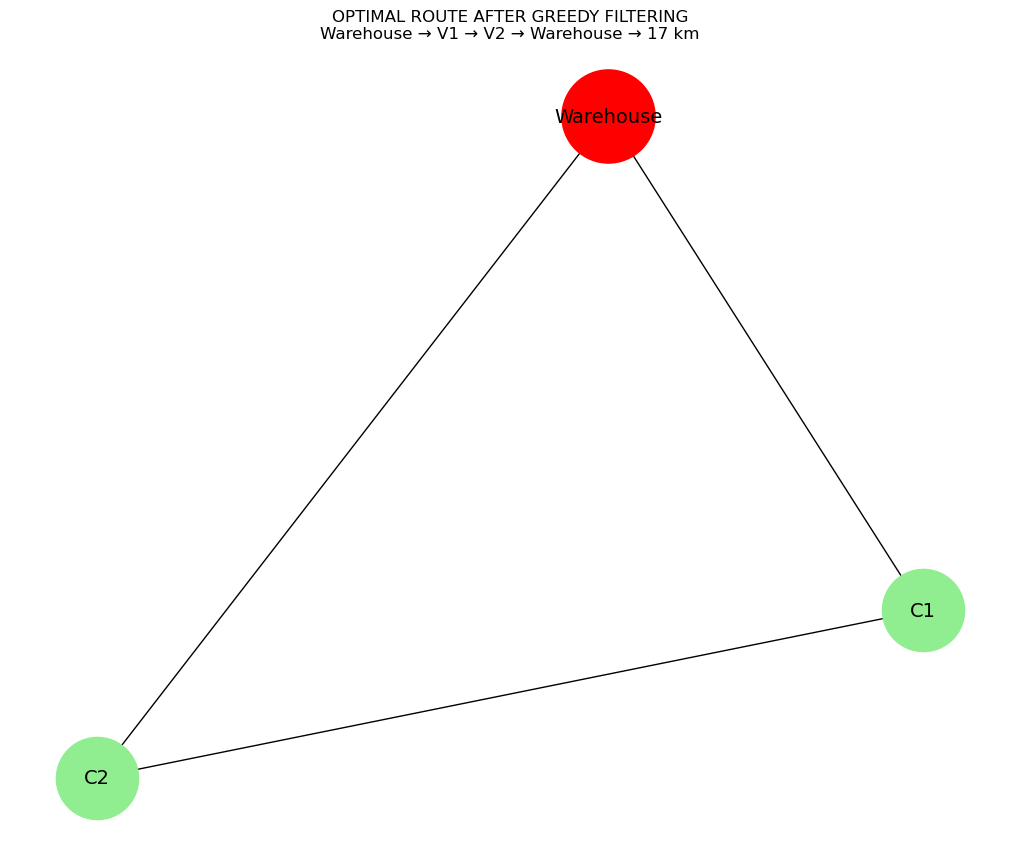

In [83]:
#Optimal Selected Route (17 km)
G_selected = nx.Graph()
for i in range(len(selected_nodes)):
    for j in range(i+1, len(selected_nodes)):
        G_selected.add_edge(selected_nodes[i], selected_nodes[j], weight=distance_matrix[locations.index(selected_nodes[i])][locations.index(selected_nodes[j])])

plt.figure(figsize=(10,8))
nx.draw(G_selected, pos, with_labels=True, node_color='lightgreen', node_size=3500, font_size=14)
nx.draw_networkx_nodes(G_selected, pos, nodelist=['Warehouse'], node_color='red', node_size=4500)

path_edges = list(zip(reduced_route, reduced_route[1:1]))
nx.draw_networkx_edges(G_selected, pos, edgelist=path_edges, edge_color='darkgreen', width=5)
plt.title(f"OPTIMAL ROUTE AFTER GREEDY FILTERING\n{' → '.join(reduced_route)} → {reduced_cost} km")
plt.savefig("optimal_route.png", dpi=300, bbox_inches='tight')
plt.show()

# Delivery Timeline

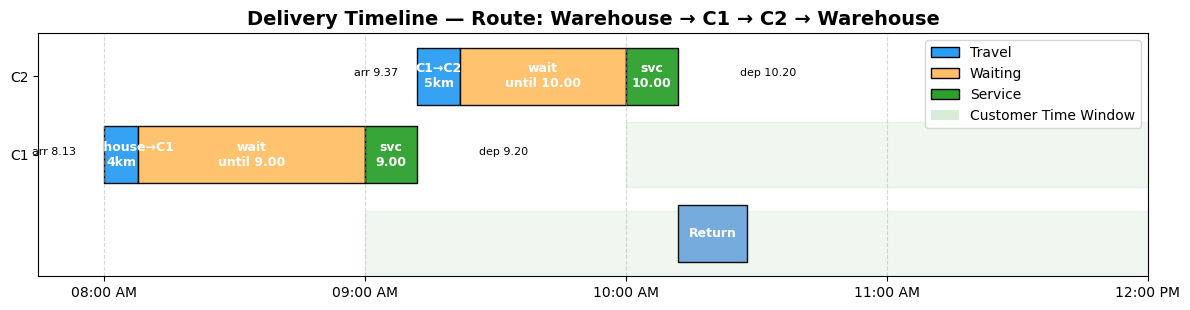

Route: Warehouse → C1 → C2 → Warehouse
Total travel end time (approx): 10.47 (hours, 24h)


In [96]:
# ...existing code...
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Improved Delivery Timeline (Gantt-style) — replaces previous cell
# Ensure route/indices exist
if 'route' not in globals() or 'indices' not in globals():
    res = check_time_windows(selected_customers)
    if res[0] is False:
        raise RuntimeError("Selected route is infeasible for time windows.")
    _, _, route, indices = res

speed = 30.0  # km/h
start_day = datetime(2025, 1, 1, 8, 0)  # reference start (8:00)
now = 8.0  # hours (float)

# Build list of delivery stops (exclude warehouse start/end)
stops = [s for s in route[1:-1]]

# Layout
n = max(1, len(stops))
row_height = 0.8
gap = 0.3
fig_h = max(3, n * (row_height + gap) + 1)
fig, ax = plt.subplots(figsize=(12, fig_h))

y_positions = {stops[i]: i * (row_height + gap) for i in range(n)}
y_return = - (row_height + gap)  # return row

service_vis = 0.2  # visual service duration in hours

# Helper: convert hour float (e.g. 8.5) to matplotlib date
def hour_to_dt(h):
    return start_day + timedelta(hours=(h - 8.0))

def draw_segment(x_start_h, duration_h, y, color, label=None, edgecolor='k', alpha=0.95):
    x0 = mdates.date2num(hour_to_dt(x_start_h))
    x1 = mdates.date2num(hour_to_dt(x_start_h + duration_h))
    ax.broken_barh([(x0, x1 - x0)], (y, row_height), facecolors=color, edgecolor=edgecolor, alpha=alpha)
    if label:
        ax.text(x0 + (x1 - x0)/2, y + row_height/2, label, ha='center', va='center', fontsize=9, color='white', weight='bold')

# Simulate route and draw
current = 8.0
for i in range(len(route)-1):
    frm = route[i]
    to = route[i+1]
    d = distance_matrix[locations.index(frm)][locations.index(to)]
    travel = d / speed
    arrival = current + travel

    if to != 'Warehouse':
        early, late = parcels[to]['time']
        wait = max(0.0, early - arrival)
        service_start = arrival + wait
        # travel (draw on receiver's row)
        y = y_positions[to]
        draw_segment(current, travel, y, '#2a9df4', f"{frm}→{to}\n{d}km")
        # waiting (amber)
        if wait > 1e-6:
            draw_segment(arrival, wait, y, '#ffbf66', f"wait\nuntil {early:.2f}")
        # service block (green)
        draw_segment(service_start, service_vis, y, '#2ca02c', f"svc\n{service_start:.2f}")
        # time-window band (very light)
        x_early = mdates.date2num(hour_to_dt(early))
        x_late = mdates.date2num(hour_to_dt(late))
        ax.axvspan(x_early, x_late, ymin=(y / (n*(row_height+gap)+row_height)), ymax=((y+row_height) / (n*(row_height+gap)+row_height)), color='green', alpha=0.06)
        # annotations
        ax.text(mdates.date2num(hour_to_dt(arrival)) - 0.01, y + row_height*0.55, f"arr {arrival:.2f}", ha='right', va='center', fontsize=8, color='black')
        ax.text(mdates.date2num(hour_to_dt(service_start + service_vis)) + 0.01, y + row_height*0.55, f"dep {service_start + service_vis:.2f}", ha='left', va='center', fontsize=8)
        # advance time
        current = service_start + service_vis
    else:
        # return leg: draw on return row
        y = y_return
        draw_segment(current, travel, y, '#6fa8dc', "Return")
        current = arrival

# Axis formatting
ax.set_ylim(y_return - 0.2, max(y_positions.values(), default=0) + row_height + 0.2)
ax.set_xlim(mdates.date2num(hour_to_dt(7.75)), mdates.date2num(hour_to_dt(max(12, current + 0.5))))
ax.set_yticks([y_positions[s] + row_height/2 for s in stops])
ax.set_yticklabels(stops)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(8, 15), interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=10)

# Grid, title, legend
ax.grid(axis='x', linestyle='--', alpha=0.5)
legend_patches = [
    mpatches.Patch(facecolor='#2a9df4', edgecolor='k', label='Travel'),
    mpatches.Patch(facecolor='#ffbf66', edgecolor='k', label='Waiting'),
    mpatches.Patch(facecolor='#2ca02c', edgecolor='k', label='Service'),
    mpatches.Patch(facecolor='green', alpha=0.15, label='Customer Time Window')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.title(f"Delivery Timeline — Route: {' → '.join(route)}", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("timeline_improved.png", dpi=300, bbox_inches='tight')
plt.show()

# Print concise schedule
print("Route:", " → ".join(route))
print(f"Total travel end time (approx): {current:.2f} (hours, 24h)")
# ...existing code...